# Wine Price Predictor<a name = 'beginning'></a>    


In this project I will apply EDA, preprocessing, XGBRegressor() and Cross-Validation. This is a purely learning project.    


The data was taken from the Kaggle database [kaggle.com](https://www.kaggle.com/)  

### Problem statement  

> to determine the price of wine   
    
### Goals of this project   

* Practice EDA: Data Loading, Data Familiarization, Data Visualization;   
* Practice Preprocessing: Outliers Excluding, Missing Values Processing, Coding Categorical Variables;  
* Practice XGBRegressor() and Cross-Validation.   

### Steps   

* [Data Loading](#loading)   
* [Getting Familiar with the Data](#familiar)    
* [Selecting Features for Model Training](#features_selection)    
* [Splitting Data](#splitting)   
* [Outliers Excluding](#outliers)     
* [Missing Values Processing](#missing_values)      
* [Combining Small Categories](#combining)    
* [Coding Categorical Variables](#coding_cv)   
* [Training the Model](#training)    
* [Model Evaluation](#evaluation)   

In [90]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.impute import SimpleImputer
%pip install xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

Note: you may need to restart the kernel to use updated packages.


## Data Loading<a name = 'loading'></a>   

[The Beginning](#beginning)  

In [38]:
data_path = 'data/winemag-data-130k-v2.csv'

data = pd.read_csv(data_path, index_col = 0)

## Getting Familiar with the Data<a name = 'familiar'></a>   

[The Beginning](#beginning)  

In [39]:
print(data.shape, '\n')

print(data.dtypes)

data.head()

(129971, 13) 

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## Selecting Features for Model Training<a name = 'features_selection'></a>               

[The Beginning](#beginning)   



Now I need to select the features that are best suited for training the model.    

Logically, one can conclude that the `description`, `taster_name`, `taster_twitter_handle` columns don't contain information that affects the price of wine. Therefore, I won't use them to train the model.   

The `designation`, `title`, and `winery` columns consist entirely or mostly of very small categories. Therefore, these columns are also uninformative for model training: 

In [40]:
print('Number of rows in the dataset: ', data.shape[0])

print('\nNumber of unique values in \'title\' column: ', data.title.nunique())

print('\nNumber of unique values in \'winery\' column: ', data.winery.nunique())

print('The largest category in \'winery\' column has ', data.winery.value_counts()[0], ' entries')

designation_counts = data['designation'].value_counts()
infrequent_designations = designation_counts[designation_counts < 100]

print('\nNumber of unique values in \'designation\' column: ', data.designation.nunique(), ', and ', 
                                      infrequent_designations.count(), ' of them have less than 100 entries')


Number of rows in the dataset:  129971

Number of unique values in 'title' column:  118840

Number of unique values in 'winery' column:  16757
The largest category in 'winery' column has  222  entries

Number of unique values in 'designation' column:  37979 , and  37951  of them have less than 100 entries


The `region_2` column consist of more than 60% empty values. So I also consider it as uninformative.    

In [41]:
# Recall total number of rows = 129 971
data.region_2.isnull().sum()

79460

### So, let's visualize remaining features to see if they do affect the price of the wine.    

Firstly I'll consider the only numerical column

<AxesSubplot:xlabel='points', ylabel='price'>

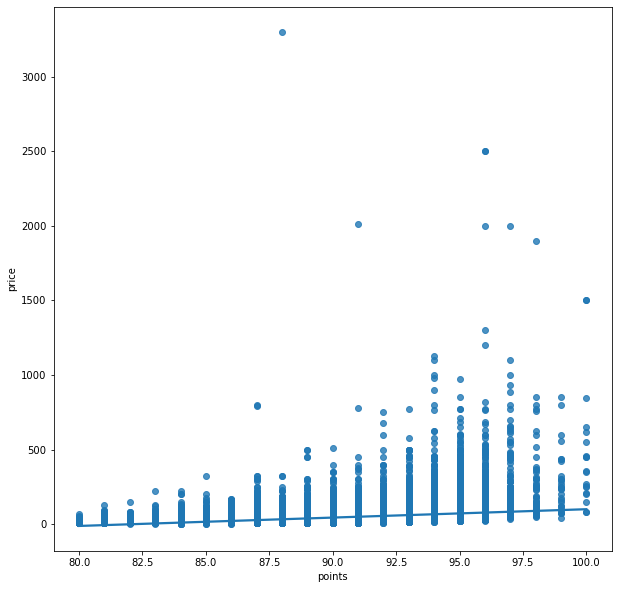

In [42]:
plt.figure(figsize=(10,10))
sns.regplot(x=data.points, y=data.price)

So far the data is heavily skewed by the presence of outliers, but even now it is clear that there is a positive correlation between `points` and `price`. So it's helpful to use this feature for model training.

Now it's time to consider categorical columns.   

I chose `pointplot` for this task rather than `violinplot` for example, because due to the number of categories in each column, I think pointplot is the easiest to understand visually.     

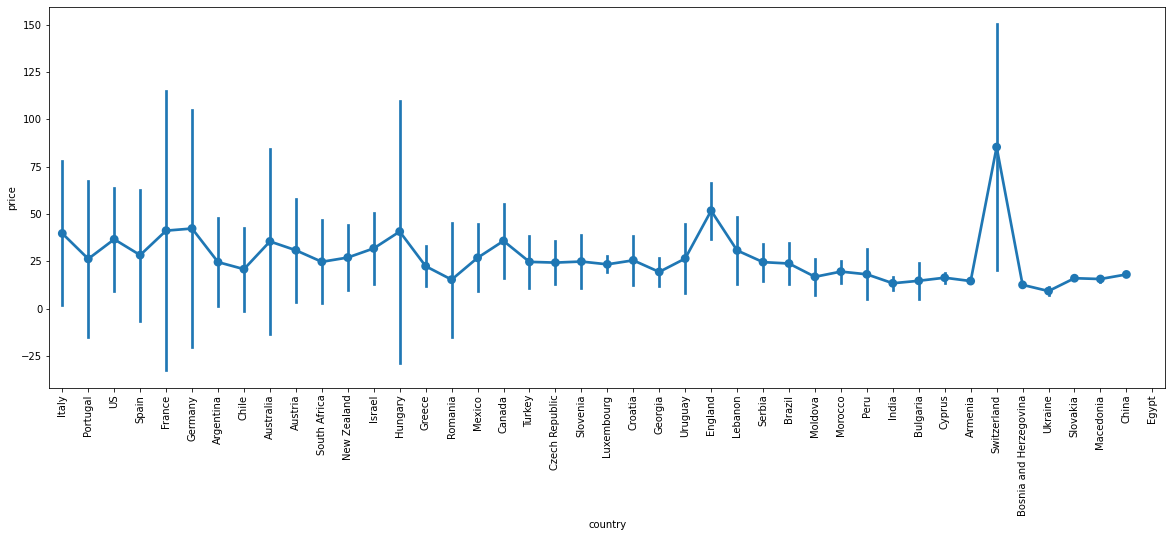

In [43]:
plt.figure(figsize=(20,7))
sns.pointplot(x='country', y='price', data=data, ci="sd")
plt.xticks(rotation=90)
plt.show()


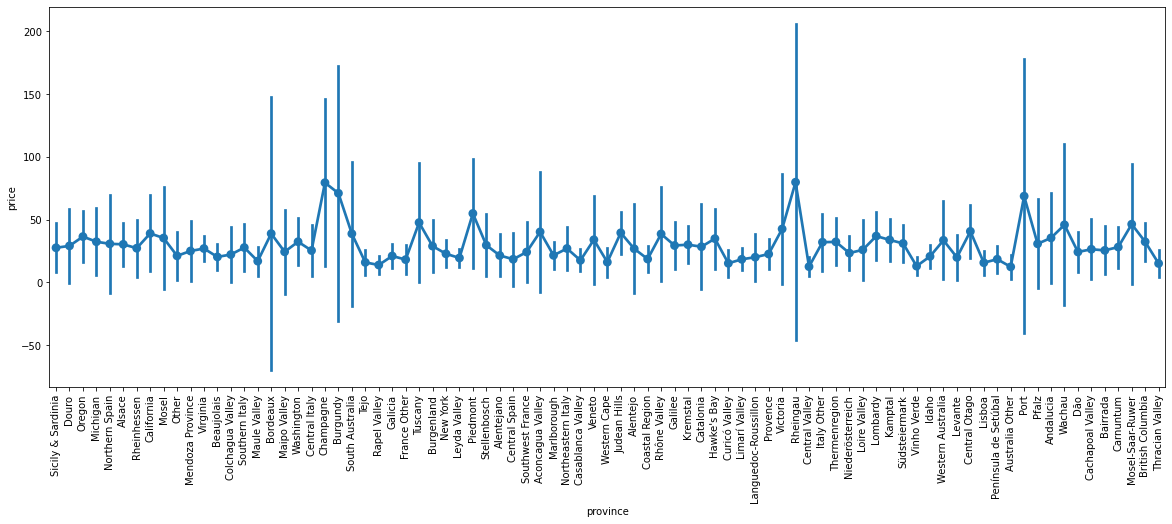

In [44]:
# For clarity, only categories with more than 100 entries will be considered. In a later step, small categories will 
# be collected as an "Other" category, so this step is not a dramatic simplification. The same approach will be applied for 
# 'region_1' and 'variety' columns.
province_counts = data.province.value_counts()

selected_provinces = province_counts[province_counts > 100].index

filtered_data = data[data.province.isin(selected_provinces)]

plt.figure(figsize=(20,7))
sns.pointplot(x='province', y='price', data=filtered_data, ci="sd")
plt.xticks(rotation=90)
plt.show()

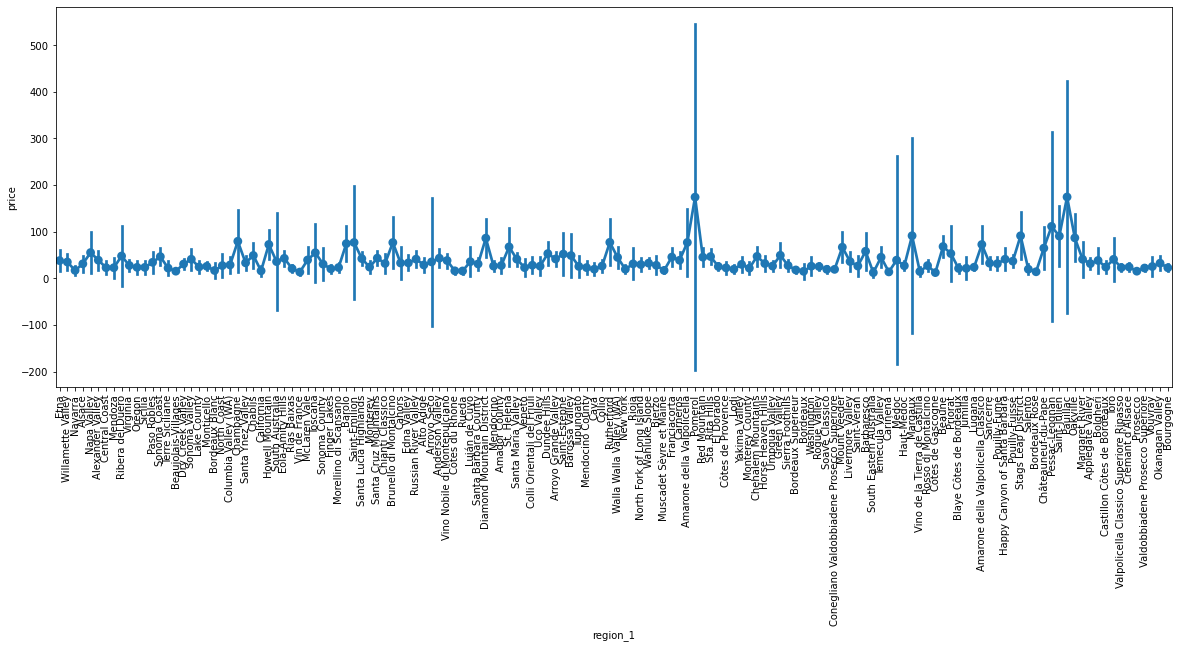

In [45]:
region_1_counts = data.region_1.value_counts()

selected_regions = region_1_counts[region_1_counts > 150].index

filtered_data = data[data.region_1.isin(selected_regions)]

plt.figure(figsize=(20,7))
sns.pointplot(x='region_1', y='price', data=filtered_data, ci="sd")
plt.xticks(rotation=90)
plt.show()

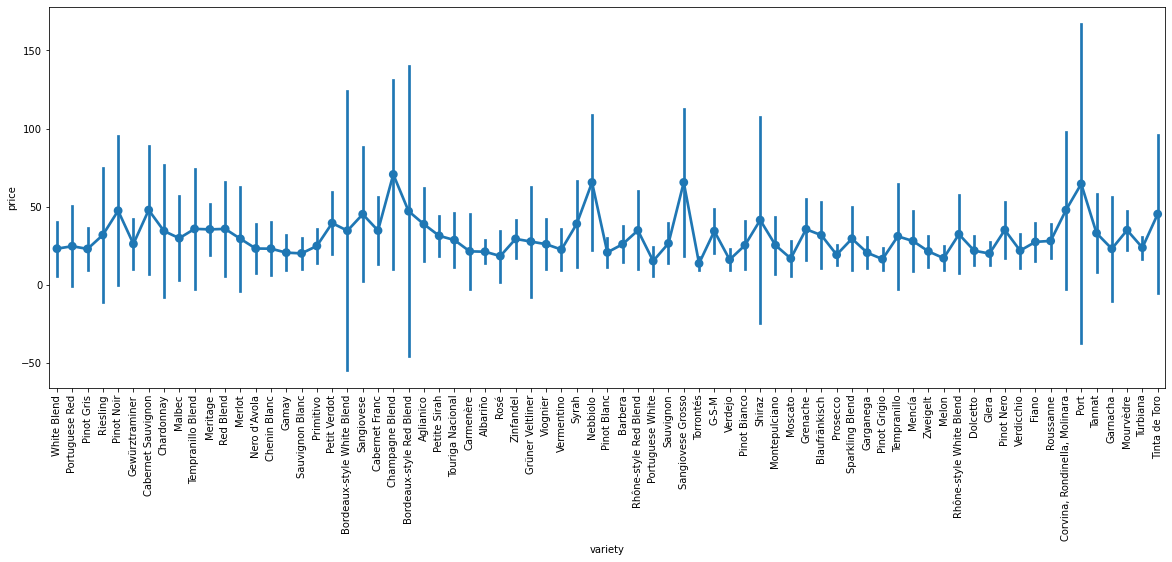

In [46]:
variety_counts = data.variety.value_counts()

selected_varieties = variety_counts[variety_counts > 150].index

filtered_data = data[data.variety.isin(selected_varieties)]

plt.figure(figsize=(20,7))
sns.pointplot(x='variety', y='price', data=filtered_data, ci="sd")
plt.xticks(rotation=90)
plt.show()

As can be seen in the graphs, all the columns considered have a correlation with the target value. Each category has a different mean value and a different spread pattern. Therefore, I conclude that the columns `country`, `province`, `region_1` and `variety` will be useful for model training.

## Splitting Data <a name = 'splitting'></a>   

[The Beginning](#beginning)  

In [47]:
data.dropna(subset = ['price'], inplace = True)

# Set the target value
y = data.price

# Create list of fetures that will be use in model training
features_to_use = ['points', 'country', 'province', 'region_1', 'variety']

# Create a specific Frame for the list of the selected features
X = data[features_to_use]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Outliers Excluding<a name='outliers'></a>   

[The Beginning](#beginning)  

<AxesSubplot:xlabel='points', ylabel='price'>

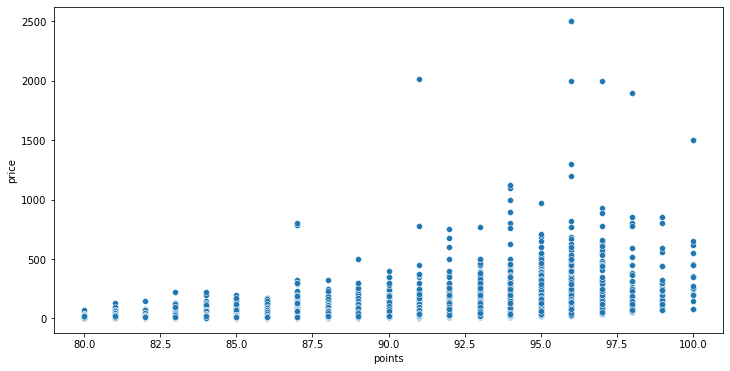

In [48]:
#Let's visualize the spread of wine prices to see wether there are outliers

plt.figure(figsize=(12,6))
sns.scatterplot(x = X_train['points'], y = y_train)

# Only train part of data is used to avoid Train-Test Contamination

In [49]:
# Collect all the train data into one variable for convenience of further computations
train_data_full = pd.concat([X_train, y_train], axis = 1)

Using IQR to find outliers and exclude them from the dataset.

In [50]:
# Calculate the Interquartile Range
quartile1, quartile3 = np.percentile(train_data_full.price, [25, 75])
iqr = quartile3 - quartile1

# Let's define the boundaries beyond which the value will be considered an outlier.
low_border = quartile1 - 1.5 * iqr
high_border = quartile3 + 1.5 * iqr

# Excluding the outliers
mask = (train_data_full.price >= low_border) & (train_data_full.price <= high_border)
train_data_full = train_data_full[mask]

Text(0.5, 1.0, 'Relationship between points and wine price')

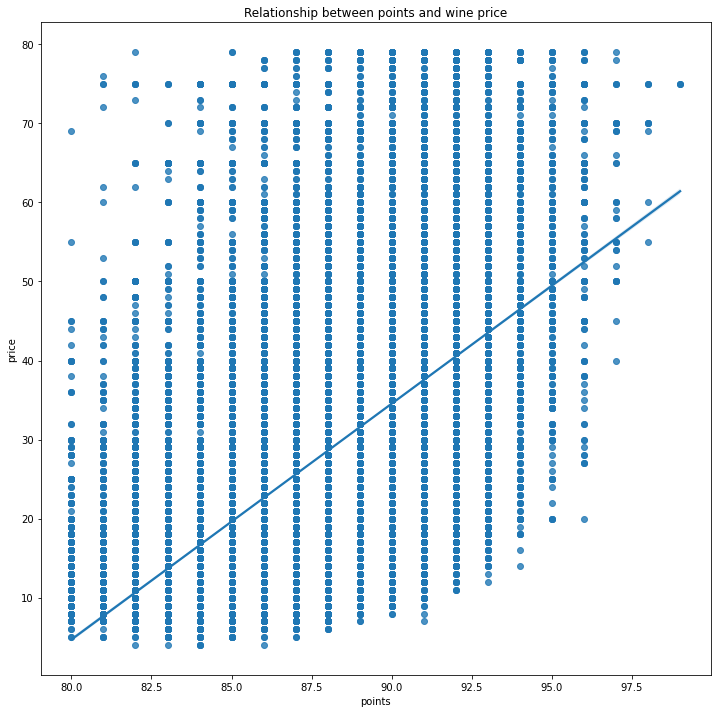

In [51]:
# Check that there are no outliers left
plt.figure(figsize=(12,12))
sns.regplot(x = train_data_full['points'], y = train_data_full['price'])
plt.title('Relationship between points and wine price')

Outliers have been eliminated. Moreover, it is now clearly seen that there is indeed a strong positive correlation between `points` and `price`.     

In [52]:
# Splitting the training data again
X_train = train_data_full[features_to_use].copy()
y_train = train_data_full.price.copy()

## Missing Values Processing<a name = 'missing_values'></a>  

[The Beginning](#beginning)   

In [53]:
# Let's check how many empty fields there are in each column
for col in X.columns:
    print(col, ' - ', X[col].isnull().sum())

# I don't check target variable, because I dropped all the missing values in it before

points  -  0
country  -  59
province  -  59
region_1  -  19575
variety  -  1


In [54]:
# Getting list of categorical cols
tuple_cat_cols = (X_train.dtypes == 'object')
cat_cols = list(tuple_cat_cols[tuple_cat_cols].index)

# Getting list of numerical cols
tuple_numerical_cols = (X_train.dtypes != 'object')
num_cols = list(tuple_numerical_cols[tuple_numerical_cols].index)

print(cat_cols, '\n')
print(num_cols)

['country', 'province', 'region_1', 'variety'] 

['points']


In [55]:
# Processing missing values in categorical columns
cat_imputer = SimpleImputer(strategy = 'most_frequent')

imputed_X_train_cat = pd.DataFrame(cat_imputer.fit_transform(X_train[cat_cols]))
imputed_X_valid_cat = pd.DataFrame(cat_imputer.transform(X_valid[cat_cols]))

# Imputation removed column names; put them back
imputed_X_train_cat.columns = X_train[cat_cols].columns
imputed_X_valid_cat.columns = X_valid[cat_cols].columns

# Processing missing values in numerical columns
num_imputer = SimpleImputer()

imputed_X_train_num = pd.DataFrame(cat_imputer.fit_transform(X_train[num_cols]))
imputed_X_valid_num = pd.DataFrame(cat_imputer.transform(X_valid[num_cols]))

# Imputation removed column names; put them back
imputed_X_train_num.columns = X_train[num_cols].columns
imputed_X_valid_num.columns = X_valid[num_cols].columns

In [56]:
# Joining numerical and categorical columns back together
imputed_X_train = pd.concat([imputed_X_train_num, imputed_X_train_cat], axis = 1)
imputed_X_valid = pd.concat([imputed_X_valid_num, imputed_X_valid_cat], axis = 1)

In [57]:
# Check that there are no empty fields left

print('Check missing values in X_train:')
for col in imputed_X_train.columns:
    print(col, ' - ', imputed_X_train[col].isnull().sum())

print('\n')

print('Check missing values in X_valid:')
for col in imputed_X_valid.columns:
    print(col, ' - ', imputed_X_valid[col].isnull().sum())

Check missing values in X_train:
points  -  0
country  -  0
province  -  0
region_1  -  0
variety  -  0


Check missing values in X_valid:
points  -  0
country  -  0
province  -  0
region_1  -  0
variety  -  0


Let's collect the categorical and numerical columns into separate variables for convenience later on.

## Combining Small Categories<a name = 'combining'></a>    

[The Beginning](#beginning)

The `province`, `region_1` and `variety` columns contain many categories, some of wich are small and therefore unimformative. Let's combine those categories into the `Other` category. 

In [58]:
imputed_X_train.province.value_counts()

California                   27168
Washington                    6664
Oregon                        4115
Tuscany                       3579
Bordeaux                      3003
                             ...  
Devon Valley                     1
Ticino                           1
Elazığ-Diyarbakir                1
Negev                            1
Leyda Valley-Maipo Valley        1
Name: province, Length: 402, dtype: int64

In [59]:
# Count the amount of entries of each value in the 'province column
province_counts = imputed_X_train.province.value_counts()

# Find values that appear less than 100 times
province_values_to_replace = province_counts[province_counts < 100].index

# Replace them with 'Other'
imputed_X_train.province.replace(province_values_to_replace, 'Other', inplace = True)

# Check the new number of categories
imputed_X_train.province.nunique()

71

Now we have 72 categories in the `province` column instead of 411.   
Let's do the same thing for the `region_1` and `variety` columns.

In [60]:
imputed_X_train.region_1.value_counts()

Columbia Valley (WA)                                 18331
Napa Valley                                           2961
Russian River Valley                                  2411
California                                            2093
Paso Robles                                           1808
                                                     ...  
Galluccio                                                1
Goulburn Valley                                          1
Vino de la Tierra Ribera del Gállego-Cinco Villas        1
Rosazzo                                                  1
Maury Sec                                                1
Name: region_1, Length: 1143, dtype: int64

In [61]:
region_1_counts = imputed_X_train.region_1.value_counts()

region_1_values_to_replace = region_1_counts[region_1_counts < 150].index

imputed_X_train.region_1.replace(region_1_values_to_replace, 'Other', inplace = True)

imputed_X_train.region_1.nunique()

98

In [62]:
imputed_X_train.variety.value_counts()

Pinot Noir            9483
Chardonnay            8501
Red Blend             6418
Cabernet Sauvignon    6311
Riesling              3812
                      ... 
Tinta Cao                1
Valvin Muscat            1
Grenache Gris            1
Biancolella              1
Barbera-Nebbiolo         1
Name: variety, Length: 659, dtype: int64

In [63]:
# Count the amount of entries of each value in the variety column
variety_counts = imputed_X_train.variety.value_counts()

# Find values that appear less than 100 times
variety_values_to_replace = variety_counts[variety_counts < 100].index

# Replace them with 'Other'
imputed_X_train.variety.replace(variety_values_to_replace, 'Other', inplace = True)

# Print the result
imputed_X_train.variety.nunique()  

79

Leave `X_valid` without changes to avoid Train-Test Contamination.

## Coding Categorical Variables<a name = 'coding_cv'></a>   

[The Beginning](#beginning)  

In [64]:
# Transforming categorical data with OrdinalEncoder. I've choosen this one, because columns have a lot of categories 
# and One-Hot Encoder for example will increase the size of data very much

# All categories that were not in the training set but were encountered in the validation set will be coded as a 
# separate category with a 999 code
ordinal_encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value= 999)

# Make copy to avoid changing the original data
label_X_train = imputed_X_train.copy()
label_X_valid = imputed_X_valid.copy()

# Apply ordinal encoder to each column with categorical data
label_X_train[cat_cols] = ordinal_encoder.fit_transform(imputed_X_train[cat_cols])
label_X_valid[cat_cols] = ordinal_encoder.transform(imputed_X_valid[cat_cols])

## Training the Model<a name = 'training'></a>  

[The Beginning](#beginning)  

In [87]:
# Choosing the ML model
model = XGBRegressor(n_estimators = 1000, learning_rate = 0.1, early_stopping_rounds = 50, random_state=42)

# Training the model on training data
model.fit(label_X_train, 
          y_train,
          eval_set = [(label_X_valid, y_valid)],
          verbose = False
         )

# Make a prediction for validation data
preds = model.predict(label_X_valid)

# Get the value of MAE
mean_absolute_error(y_valid, preds)

12.510494788182276

## Model Evaluation<a name = 'evaluation'></a>      

[The Beginning](#beginning)  

With Cross-Validation, I won't be able to find the optimal number of trees using `early_stopping_rounds`, so I need to know it in advance.

In [89]:
optimal_trees_number = model.best_iteration
print(optimal_trees_number)

267


In [99]:
model = XGBRegressor(n_estimators = optimal_trees_number, learning_rate = 0.1, random_state=42)

scores = -1 * cross_val_score(model, 
                        pd.concat([label_X_train, label_X_valid]),
                        pd.concat([y_train, y_valid]),
                        cv = 5,
                        scoring = 'neg_mean_absolute_error'
                       )

print(scores.mean())

9.042397282897415


In [102]:
y_full = pd.concat([y_train, y_valid])

scores.mean() / y_full.mean()

0.2972124827422054